In [253]:
import gymnasium as gym
import numpy as np
gym.__version__

'0.29.0'

In [254]:
env = gym.make("LunarLander-v2")

From [docs](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

## Action Space
There are four discrete actions available:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine


In [255]:
env.action_space

Discrete(4)


## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.


In [256]:
print(env.observation_space.shape)
env.observation_space

(8,)


Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)

## Rewards
After every step a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.
An episode is considered a solution if it scores at least 200 points.

## Taking a step

In [257]:
env.reset()
observation, reward, terminated, truncated, info = env.step(0)
reward

-0.3011512839212571

## Reinforcement Learning Objective

Our performance measure: 

$$
J(\theta) = \mathbb{E} \left[ \sum_{t=0}^{T-1}r_{t+1} \right]
$$

and our update rule:

$$
\theta \leftarrow \theta + \frac{\partial}{\partial \theta} J(\theta)
$$

The gradient
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a q_\pi(S_t, a) \nabla \pi (a | S_t, \theta) \right]
$$
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ \sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \frac{\nabla \pi (a | S_t, \theta)}{\pi (a | S_t, \theta)} \right]
$$

If we sample $A_t \sim \pi$, then we just replace the expectation over $a$ with the sample $A_t$. So we're doing this swap from expectation to sample:
$$
\sum_a \pi (a | S_t, \theta) q_\pi(S_t, a) \rightarrow q_\pi(S_t, A_t)
$$
which then simplifies $\nabla J(\theta)$ to

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ q_\pi(S_t, A_t) \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

and by $\mathbb{E}_\pi [G_t | S_t, A_t] = q_\pi (S_t, A_t)$,

$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \frac{\nabla \pi (A_t | S_t, \theta)}{\pi (A_t | S_t, \theta)} \right]
$$

We're going to make one more simplification: note that $\nabla \ln x = \frac{\nabla x}{x}$, so
$$
\nabla J (\theta) = \mathbb{E}_\pi \left[ G_t \nabla \ln \pi (A_t | S_t, \theta) \right]
$$

Now, we can actually calculate the value in brackets at each time step, and can then use it to update $\theta$:

$$
\theta_{t+1} = \theta_t + \alpha G_t \nabla \ln \pi(A_t | S_t, \theta_t)
$$

We're now going to generate an episode $S_0, A_0, R_1,...,S_{T-1}, A_{T-1}, R_T$.

In [258]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize policy network
# takes in a state, determines the next action
class PolicyNetwork(nn.Module):
    def __init__(self, obs_size, action_size):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(obs_size, action_size, bias=False),
            nn.ReLU()
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.layer(x)
        return torch.log(F.softmax(logits, dim=-1) + 1e-9)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        log_probs = self.forward(state).squeeze(0)
        probs = torch.exp(log_probs)
        action = torch.multinomial(probs, 1)
        return action.item(), log_probs[action]
    
model = PolicyNetwork(env.observation_space.shape[0], (env.action_space.n - env.action_space.start))

Here is a full episode of the moon landing.

In [259]:
def run_episode(model, env=env):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

Notice how `log_probs` is an array of `torch.tensor`. We need this to be the case, because we have to run `.backward` on it later to calculate the gradients. Without doing this, we can't really use pytorch to do the heavy lifting for us.

Now, at the end of the episode, we need to determine $G$, the expected reward at each timestep.

In [260]:
def discount_rewards(rewards, gamma=.99):
    G = []
    R = 0
    for i in reversed(range(len(rewards))):
        R = rewards[i] + gamma * R
        G.insert(0, R)
    return G

# test it
r = np.array([1,1,1,1,1])
g = np.array(discount_rewards(r))
t = np.array([4.90099501, 3.940399, 2.9701, 1.99, 1])
assert np.allclose(g, t), "Incorrect sum of discounted rewards"
del r, g, t

In [261]:
def update(model, log_probs, rewards, alpha=0.01, gamma=0.99):
    # compute the discounted rewards
    G = discount_rewards(rewards, gamma)
    for t in range(len(G)):
        log_prob = log_probs[t]
        g = G[t]

        model.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients of log pi(A_t, S_t, theta) at each timestep
        for param in model.parameters():
            if param.grad is not None:
                param.grad = alpha * gamma**t * g * param.grad # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        model.optimizer.step() # update the weights using the gradients

# testing the update function
model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)

rewards, log_probs, actions, observations = run_episode(model)

old = list(model.parameters())[0].clone()
update(model, log_probs, rewards, alpha=1., gamma=1.) # no discounting, no scaling
new = list(model.parameters())[0].clone()

delta = new - old
print(delta)

left_leg_contact = (observations[:, -2]).sum() > 0
right_leg_contact = (observations[:, -1]).sum() > 0

left_leg_delta = delta[:, -2].sum(axis=0)
right_leg_delta = delta[:, -1].sum(axis=0)

# if there was no right leg contact, the right leg should have 0 delta
assert left_leg_contact == True or left_leg_delta == 0.
assert right_leg_contact == True or right_leg_delta == 0.

# del model, rewards, log_probs

tensor([[-7.8811e-03, -6.5490e-03, -7.1798e-03,  7.3518e-03,  1.0625e-02,
          3.9752e-03,  1.9509e-03,  0.0000e+00],
        [ 1.9477e-03,  1.9461e-03,  1.9477e-03, -1.9502e-03, -1.9509e-03,
         -8.0213e-05,  1.9481e-03,  0.0000e+00],
        [ 1.7566e-03, -2.6492e-03, -2.5835e-03,  2.0991e-03, -1.2205e-03,
          4.2160e-03,  0.0000e+00,  0.0000e+00],
        [ 1.3075e-02,  1.4704e-02,  1.4443e-02, -1.3452e-02, -2.1751e-02,
         -2.5636e-02,  1.9965e-04,  0.0000e+00]], grad_fn=<SubBackward0>)


So the thing that's confusing me about this is: how could we be getting no changes in some of the weights? If we analyze the weight matrix, what we're seeing is the following table of how much each weight is changing:

|                      | x-coord | y-coord | x-vel | y-vel | angle | angular-vel | left-leg-contact | right-leg-contact |
|----------------------|---------|---------|-------|-------|-------|-------------|------------------|-------------------|
| action 0: no-op      |         |         |       |       |       |             |                  |                   |
| action 1: fire left  |         |         |       |       |       |             |                  |                   |
| action 2: fire main  |         |         |       |       |       |             |                  |                   |
| action 3: fire right |         |         |       |       |       |             |                  |                   |

It makes sense as to why the policy gradient would be 0 for the left and right leg contact, if in the given episode it never made contact (the lander spun upside-down).

Now a policy with no priors will draw from the actions equally, and with 20 steps it's basically certain that we'll choose each of the four actions at least once. So that's what's confusing to me: how is it that we're basically guaranteed to try all the actions but yield 0 delta.

And now we'll try it for a bunch of episodes.

In [262]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(10000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

KeyboardInterrupt: 

So at some point in training, we run an episode which totally goes off the rails, yielding a reward that is many standard deviations from the normal range. I think the sessions are also probably longer too, because the lunar lander is just wizzing around, yielding bad rewards and many timesteps. We can check this easily by plotting the number of steps in an episode.

In [263]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = fig.add_subplot(1,2,1)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

KeyboardInterrupt: 

Yep, so we need to cap our episode lengths. If we don't solve within say 1000 steps, it should just be a failure.

In [264]:
def run_episode(model, env=env, max_steps=1000):
    observation, _ = env.reset()

    rewards = []
    log_probs = []
    actions = []
    observations = []

    steps = 0

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        steps += 1

        actions.append(action)
        rewards.append(reward)
        log_probs.append(_log_probs)
        observations.append(observation)

        if terminated:
            break

        if steps >= max_steps:
            break

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, actions, np.array(observations)

model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
rewards, log_probs, actions, observations = run_episode(model)

# print(rewards.shape)
# print(len(log_probs))
# print(actions)
# print(observations)

del model, rewards, log_probs, actions, observations

In [265]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = fig.add_subplot(1,2,1)

for i in range(5000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

KeyboardInterrupt: 

Interesting: the policy that we're learning is now just learning to fly off without landing. The behavior we're learning is to not actually land, but to not crash. Note how the score is never breaking above 100, so it's likely never learning to land. We can check this as well by plotting the moving average of how many episodes end with both legs in contact.

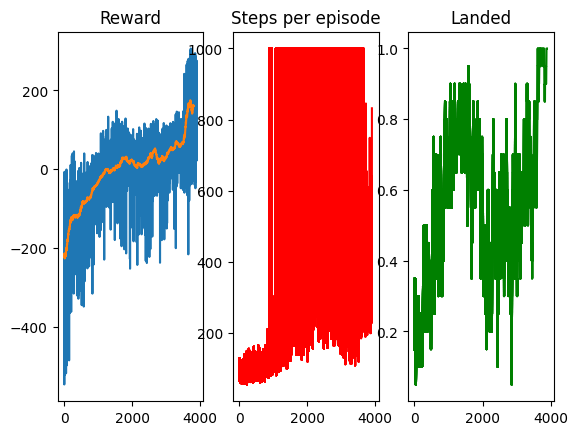

In [276]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

network_shape = env.observation_space.shape[0], (env.action_space.n - env.action_space.start)
model = PolicyNetwork(*network_shape)

rewards_track = []
steps_per_episode = []
landed = []

fig = plt.figure()
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

for i in range(4000):
    rewards, log_probs, actions, observations = run_episode(model)
    update(model, log_probs, rewards)

    rewards_track += [sum(rewards).detach().tolist()]
    steps_per_episode += [len(actions)]
    landed += [observations[-1, -2:].sum() == 2]

    if i % 100 == 0:
        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")

        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        # also plot the number of steps
        ax2.plot(steps_per_episode, color='red')
        ax2.set_title("Steps per episode")

        # and the number of times we landed
        ax3.set_title("Landed")
        if len(landed) > 20:
            smoothed = [np.mean(landed[i:i+20]) for i in range(len(landed) - 20)]
            ax3.plot(smoothed, color='green')

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

In [ ]:
import torch
import torch.nn as nn

# takes in a state, estimates the value of the state v(s)
class StateValueNetwork(nn.Module):
    def __init__(self, state_size, hidden_size=128):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, state):
        return self.layer(torch.tensor(state))
    
model = StateValueNetwork(env.observation_space.shape[0])
observation, _ = env.reset()
model(observation)

tensor([-0.0150], grad_fn=<AddBackward0>)

In [ ]:
def run_episode(model, env=env):
    observation, _ = env.reset()
    step = 0

    rewards = []
    log_probs = []
    states = [observation]

    while True:
        action, _log_probs = model.act(observation)
        observation, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)
        log_probs.append(_log_probs)
        states.append(observation)

        if terminated:
            observation = env.reset()
            break
        step += 1

    rewards = torch.tensor(rewards)
    
    return rewards, log_probs, states

model = PolicyNetwork(*network_shape)
rewards, log_probs, states = run_episode(model)

In [ ]:
def update_with_baseline(policy_model, state_value_model, log_probs, discounted_rewards, states, alpha=0.01):
    for (t,(log_prob, reward, state)) in enumerate(zip(log_probs, discounted_rewards, states)):
        
        # update for the state value model
        baseline = state_value_model(state)
        state_value_model.optimizer.zero_grad() # reset the gradients
        baseline.backward()
        for param in state_value_model.parameters():
            if param.grad is not None:
                alpha = .1 / torch.mean(param.grad**2)
                param.grad = alpha * (reward - baseline) * param.grad
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        state_value_model.optimizer.step() # update the weights using the gradients

        # updates for the policy model
        policy_model.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients for each log pi(A_t, S_t, theta)
        for param in policy_model.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * gamma**t * param.grad   # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        policy_model.optimizer.step() # update the weights using the gradients

policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
state_value = StateValueNetwork(env.observation_space.shape[0])
update_with_baseline(policy, state_value, log_probs, discount_rewards(rewards, gamma), states)

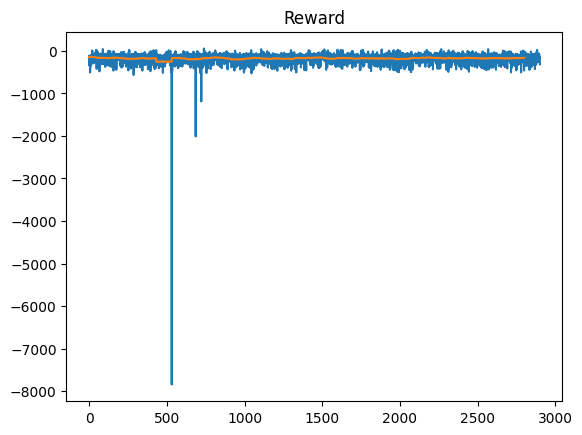

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

policy = PolicyNetwork(*network_shape)
state = StateValueNetwork(env.observation_space.shape[0])

rewards_track = []
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(3000):
    rewards, log_probs, states = run_episode(model)
    d_rewards = discount_rewards(rewards, gamma)
    update_with_baseline(policy, state, log_probs, d_rewards, states)

    rewards_track += [sum(rewards).detach().tolist()]

    if i % 100 == 0:

        ax.clear()
        ax.plot(rewards_track)
        ax.set_title("Reward")
        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax.plot(smoothed)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break

Alright, so something is broken in our implementation of the state value. Let's try to fix it. Good first check is on the gradients. Are they flowing?

In [ ]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, f"{100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())}%") for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(state)

[('layer.0.weight', '0.0%'),
 ('layer.0.bias', '0.0%'),
 ('layer.2.weight', '0.0%'),
 ('layer.2.bias', '0.0%')]

So none of our gradients are at 0. That's good. Let's check how they're distributed. Ideally, we want them to be centered around 0 and have a small variance. This means that the gradients are neither too big nor too small, and that they're both positive and negative.

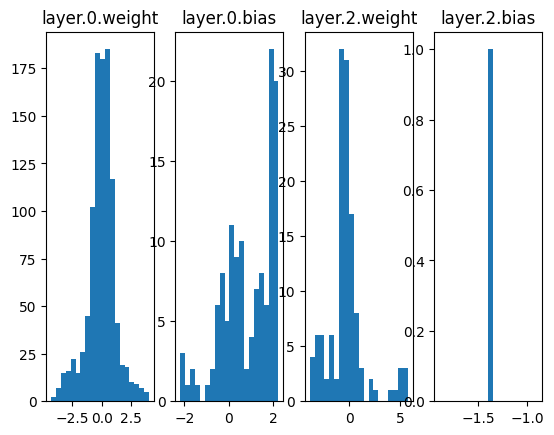

In [ ]:

fig, ax = plt.subplots(1, len(list(state.parameters())))
for (i, (name, param)) in enumerate(state.named_parameters()):
    # set the subplot title to be the parameter name
    ax[i].set_title(name)
    # plot the parameter values
    ax[i].hist(param.flatten().detach().numpy(), bins=20)

I think we need to normalize the gradient values, much like batch RMS.

In [ ]:
def update_with_baseline(pm, sm, log_probs, discounted_rewards, states, alpha=0.01):
    for (t,(log_prob, reward, state)) in enumerate(zip(log_probs, discounted_rewards, states)):
        # update for the state value model
        baseline = sm(state)
        sm.optimizer.zero_grad() # reset the gradients
        baseline.backward()
        for param in sm.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * param.grad
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        sm.optimizer.step() # update the weights using the gradients

        # updates for the policy model
        pm.optimizer.zero_grad() # reset the gradients
        log_prob.backward() # compute the gradients for each log pi(A_t, S_t, theta)
        for param in pm.parameters():
            if param.grad is not None:
                param.grad = alpha * (reward - baseline) * gamma**t * param.grad   # scale the gradients by the reward
                param.grad = param.grad * -1. # flip the gradients (maximize the reward)
        pm.optimizer.step() # update the weights using the gradients

p = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
s = StateValueNetwork(env.observation_space.shape[0])
update_with_baseline(p, s, log_probs, discount_rewards(rewards, gamma), states)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

The values network should be converging to the true values of the states. The way in which we can determine this is by looking at the difference between the reward for the state and the value for the state, and they should get closer.

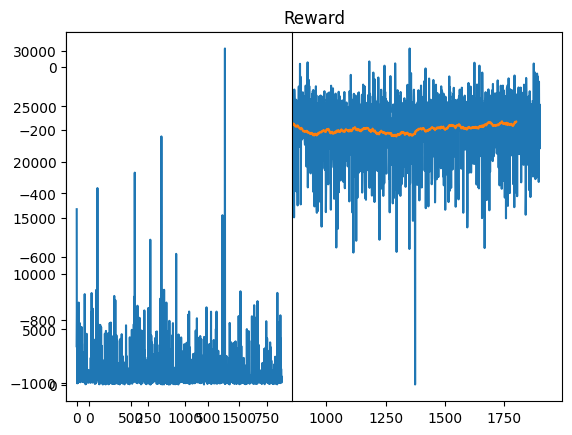

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

policy = PolicyNetwork(*network_shape)
state = StateValueNetwork(env.observation_space.shape[0])

diffs = []
rewards_track = []

# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)
# ax2 = fig.add_subplot(1,2,1)

for i in range(2000):
    rewards, log_probs, states = run_episode(model)
    d_rewards = discount_rewards(rewards, gamma)
    update_with_baseline(policy, state, log_probs, d_rewards, states)

    rewards_track += [sum(rewards).detach().tolist()]

    v_hat = state(states)[:-1]
    diffs += [((d_rewards - v_hat)**2).mean().detach().tolist()]

    if i % 100 == 0:
        ax1.clear()
        ax1.plot(rewards_track)
        ax1.set_title("Reward")
        # add a smoothed version
        if len(rewards_track) > 100:
            smoothed = [np.mean(rewards_track[i:i+100]) for i in range(len(rewards_track) - 100)]
            ax1.plot(smoothed)
        
        ax2.clear()
        ax2.plot(diffs)

        display(fig)
        clear_output(wait=True)
        plt.pause(0.001)

        if sum(rewards_track[-100:]) / 100 > 195:
            print("Solved!")
            break